In [1]:
# Merger rate for IMRIPY system when they throw away all of the dark matter before merging.

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})    


π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
t_0 = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr

σ_eq = 0.005
ρ_m = 4e19                #ρ_m = 4e19 M☉ Gpc^-3


m_1 = 7   #in units of M☉
m_2 = 9  #in units of M☉

y_1 = np.log(m_1)
y_2 = np.log(m_2)
dy = (y_2-y_1)


y_list = np.zeros(11)

for i in range(len(y_list)):
    y_list[i] = (y_1 + (i*dy))
    

M_1_list = np.zeros(len(y_list))
M_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i] = (np.ceil(np.exp(y)))
    M_2_list[i] = (np.ceil(np.exp(y)))
    

            
m_1_list = [int(M_1) for M_1 in M_1_list]
m_2_list = [int(M_2) for M_2 in M_2_list]

    
Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy)
    Δ_2_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy) 
    
    
        
m_1 = 1        # m_1 = 1 solar mass
a_i = 1e10     # in units of pc
e_i = 0.9999
j_i = np.sqrt(1 - (e_i**2))



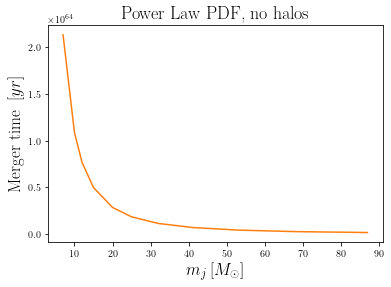

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


def merger_time_nohalos(m_2):  # assuming a_i = a_f and hence j_i = j_f .
    return  (((a_i**4) * (c**5))/((85/3) * (G**3) * (m_1 * m_2 * (m_1 + m_2)))) * (j_i**7)






merger_time_nohalos_list = np.zeros(len(m_2_list))

for i, m_2 in enumerate(m_2_list):
    merger_time_nohalos_list[i] = merger_time_nohalos(m_2)

plt.plot(m_2_list, merger_time_nohalos_list, 'C1')



plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Merger time $\: [yr]$', fontsize = 17)
plt.title('Power Law PDF, no halos', fontsize = 18)
plt.show()     

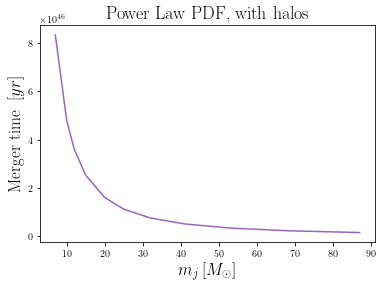

In [4]:

def merger_time_withhalos(m_2):  # j_f = sqrt(a_i /a_f) * j_i
    
    def x(m_1, m_2):  # Let a_i = (0.0965 * λ *x)
        return  (((3 * (m_1 + m_2 ) * a_i)/(8 * π * ρ_eq))**(1/4)) * ((0.0965)**(-1/4))
    
    def λ(m_1, m_2):
        return (a_i / (0.0965 * x(m_1, m_2)))
    
    
    def s(m_1, m_2): # S_dec of the binary decouple.
        return ((0.03095*λ(m_1, m_2)+ 0.3425)*λ(m_1, m_2))
    
    
    def t(m_1, m_2):    # t_dec of the binary decouple.
        return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(m_1, m_2)-2)*np.sqrt(s(m_1, m_2)+1))+(4/3)))
  
    
    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    
    
    def M_1halo(m_1, m_2):
        return (((16*π)/3)*ρ_bar(m_1)*((2*G*m_1*(t(m_1, m_2)**2))**(1/4)))
    
    
    def M_2halo(m_1, m_2):
        return (((16*π)/3)*ρ_bar(m_2)*((2*G*m_2*(t(m_1, m_2)**2))**(1/4)))
    

    def M_binary_initial(m_1, m_2):
        return (m_1 + m_2 + M_1halo(m_1, m_2) + M_2halo(m_1, m_2))
      
    def M_1(m_1, m_2):
        return (m_1 + M_1halo(m_1, m_2))
    
    def M_2(m_1, m_2):
        return (m_2 + M_2halo(m_1, m_2))
    
    #Schwarzchild Radius of the PBH.
    def r_s(m): 
        return ((2*G*m)/(c**2)) 


    #r_turnaround of the dark matter halos, eq.(5) in "WIMPs and stellar-mass primordial black holes are incompatible"
    def r_ta(m): 
        return ((2*G*m*(t(m_1, m_2)**2))**(1/3))


    # The binding energy, E_b of the dark matter halos calculated within r_s and r_ta for dark matter halo's density profile of ρ(r)∝ r^{-9/4}
    def E_b(m): 
        return ((16*π*G*ρ_bar(m)*m*(((r_ta(m))**(-1/4))-((r_s(m))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(m)**2)*(((r_ta(m))**(1/2))-((r_s(m))**(1/2)))))
    
    
    def a_final(m_1,m_2):
        return ((G* m_1 * m_2)/((G * M_1(m_1, m_2) * M_2(m_1, m_2))-(2 * a_i *(E_b(m_1)+E_b(m_2)))))

    
    def j_f(m_1,m_2):
        return np.sqrt(a_i / a_final(m_1, m_2)) * j_i
    
    
    return  (((a_final(m_1, m_2)**4) * (c**5)) / ((85/3) * (G**3) * m_1 * m_2  * (m_1 + m_2))) * (j_f(m_1,m_2)**7)



plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


merger_time_withhalos_list = np.zeros(len(m_2_list))

for i, m_2 in enumerate(m_2_list):
    merger_time_withhalos_list[i] = merger_time_withhalos(m_2)

plt.plot(m_2_list, merger_time_withhalos_list, 'C4')



plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Merger time $\: [yr]$', fontsize = 17)
plt.title('Power Law PDF, with halos', fontsize = 18)
plt.show()     

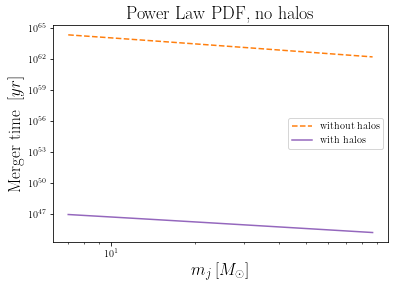

In [5]:
plt.loglog(m_2_list, merger_time_nohalos_list, 'C1--')
plt.loglog(m_2_list, merger_time_withhalos_list, 'C4')

plt.legend(["without halos", "with halos"])
plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Merger time $\: [yr]$', fontsize = 17)
plt.title('Power Law PDF, no halos', fontsize = 18)
plt.savefig('timePWRLaw.pdf', bbox_inches = 'tight')
plt.show() 

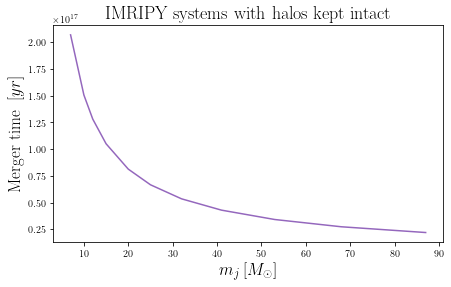

In [27]:
def merger_time_imripy(m_2):
    
    beta = 0.75
    gamma  =  0.65
    delta = -0.89
    a_i_ref = (1e4 * 0.04606)   # in units of pc
    m1_ref = 1      # in units of solar mass.
    m2_ref = 1e-3   # in units of solar mass.
    
    
    file = np.load('tmofj0.npz')
    ji_ref_list = file['arr_0']
    tm_ref_list = file['arr_1']


    # right now tm_ref_list contains 40 points in the list. 
    tm_ref =  InterpolatedUnivariateSpline(tm_ref_list, ji_ref_list, k = 2) # j_i = g(t_m)
     
    return tm_ref(j_i) * ((a_i / a_i_ref)**(beta)) * ((m_1/m1_ref)**(gamma)) * ((m_2 / m2_ref)**(delta))



merger_time_imripy_list = np.zeros(len(m_2_list))

for i, m_2 in enumerate(m_2_list):
    merger_time_imripy_list[i] = merger_time_imripy(m_2)


    
    
plt.figure(figsize=(7,4))    
    
plt.plot(m_2_list, merger_time_imripy_list, 'C4')
plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Merger time $\: [yr]$', fontsize = 17)
plt.title('IMRIPY systems with halos kept intact', fontsize = 18)
plt.show()     

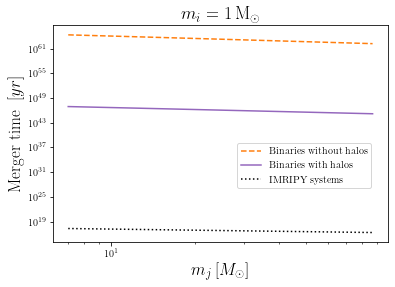

In [28]:
plt.loglog(m_2_list, merger_time_nohalos_list, 'C1--')
plt.loglog(m_2_list, merger_time_withhalos_list, 'C4')
plt.loglog(m_2_list, merger_time_imripy_list, 'k:')
plt.legend(["Binaries without halos", "Binaries with halos", "IMRIPY systems"], loc = (0.55, 0.25))
plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Merger time $\: [yr]$', fontsize = 17)
plt.title('$m_{i} = 1 \, \mathrm{M_{\odot}}$', fontsize = 18)
plt.savefig('mergertime.pdf', bbox_inches = 'tight')
plt.show()  

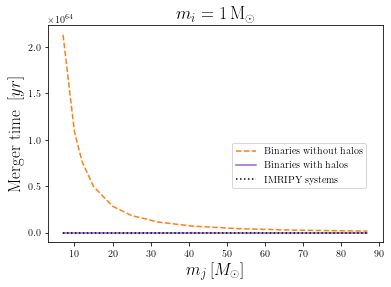

In [29]:
plt.plot(m_2_list, merger_time_nohalos_list, 'C1--')
plt.plot(m_2_list, merger_time_withhalos_list, 'C4')
plt.plot(m_2_list, merger_time_imripy_list, 'k:')
plt.legend(["Binaries without halos", "Binaries with halos", "IMRIPY systems"], loc = (0.55, 0.25))
plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Merger time $\: [yr]$', fontsize = 17)
plt.title('$m_{i} = 1 \, \mathrm{M_{\odot}}$', fontsize = 18)
plt.savefig('mergertime_linearscale.pdf', bbox_inches = 'tight')
plt.show() 